<a href="https://colab.research.google.com/github/ThreeOwl31/json/blob/main/ExperimentoSensores_residencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmo prophet

## Importar librerias

En esta parte se importó la librería de prophet, numpy, pandas, matplotlib, plotly, seaborn

In [ ]:
from prophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py
import seaborn as sns
py.init_notebook_mode()
from sklearn.metrics import roc_curve
%matplotlib inline

Montamos el servicio en la nube Google Drive para importar nuestro documento con el cual vamos a trabajar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Leemos el csv en la direccion en la ruta en la que se encuentra dentro de nuestro drive, este documento debe estar en formato CSV

In [ ]:
#Lectura del dataframe
df = pd.read_csv('drive/MyDrive/Classroom/Exp/experimento.csv')

Observamos los datos del documento, en este caso nos importa que la columna de tiempo este esrandarizado en el formato que deseemos, en este caso el formato DD-MM-YYYY hh:mm:ss

In [ ]:
df.tail()

Fecha/Hora  Temperatura   CO2  Presion  Aire
4373  13-10-2022 15:13:03         43.2  2710     1880  7318
4374  13-10-2022 15:13:06         42.6  2710     1882  7318
4375  13-10-2022 15:13:08         43.0  2706     1841  7321
4376  13-10-2022 15:13:10         43.5  2710     1873  7318
4377  13-10-2022 15:13:12         43.6  2715     1870  7318

Observamos la informacion de los datos en las columnas, si hay valores nulos o el tipo de dato donde observamos que todos los sensores arrojan tipo int a excepcion del de temperatura que arroja float, esto para una mayor precision en los datos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4378 entries, 0 to 4377
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Fecha/Hora   4378 non-null   object 
 1   Temperatura  4378 non-null   float64
 2   CO2          4378 non-null   int64  
 3   Presion      4378 non-null   int64  
 4   Aire         4378 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 171.1+ KB


Observamos algunos datos estadisticos de los sensores donde nos importa especialmente la media, la minima y la maxima, donde vemos que hay valores que se encuentran en 0, lo cual observaremos si estos manipulan el algortimo

In [ ]:
df.describe()

Temperatura          CO2      Presion         Aire
count  4378.000000  4378.000000  4378.000000  4378.000000
mean     42.066743  2687.652810  1862.664002  7296.235724
std       3.012033   204.134289   113.466682   427.943217
min       0.000000     0.000000     0.000000     0.000000
25%      41.200000  2697.000000  1851.000000  7318.000000
50%      42.300000  2706.000000  1877.000000  7321.000000
75%      43.500000  2710.000000  1887.000000  7326.000000
max      51.400000  2737.000000  2021.000000  7684.000000

In [ ]:
#df1 = df.sort_values('tiempo')

Tamaño del dataset

In [ ]:
df.size

21890

Observamos el periodo de tiempo en el que se ubica nuestro dataset

In [ ]:
#Fecha minima y máxima
print('Fecha min',df['Fecha/Hora'].min())
print('Fecha max',df['Fecha/Hora'].max())

Fecha min 13-10-2022 12:57:09
Fecha max 13-10-2022 15:13:12


Graficacion de la serie de tiempos

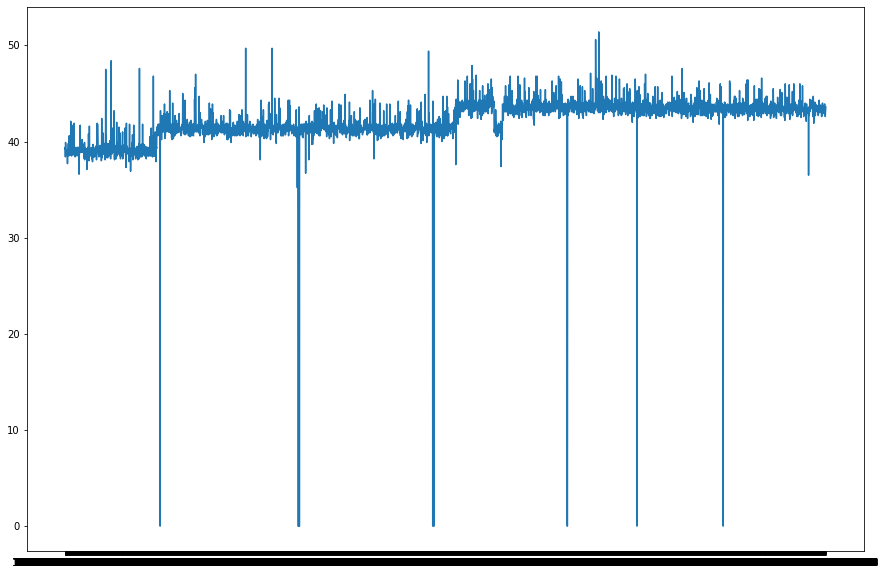

In [ ]:
#Graficamos la serie de tiempo
plt.figure(figsize=(15,10))
plt.plot(df['Fecha/Hora'],df['Temperatura'])

Detectamos que los valores cero, son valores que no estan ligados al caso real debido a un corto o falla del sensor y no tanto por que sea un valor real detectado, los eliminaremos

In [ ]:
df1 =df.drop(df[df['Temperatura']<=0].index)

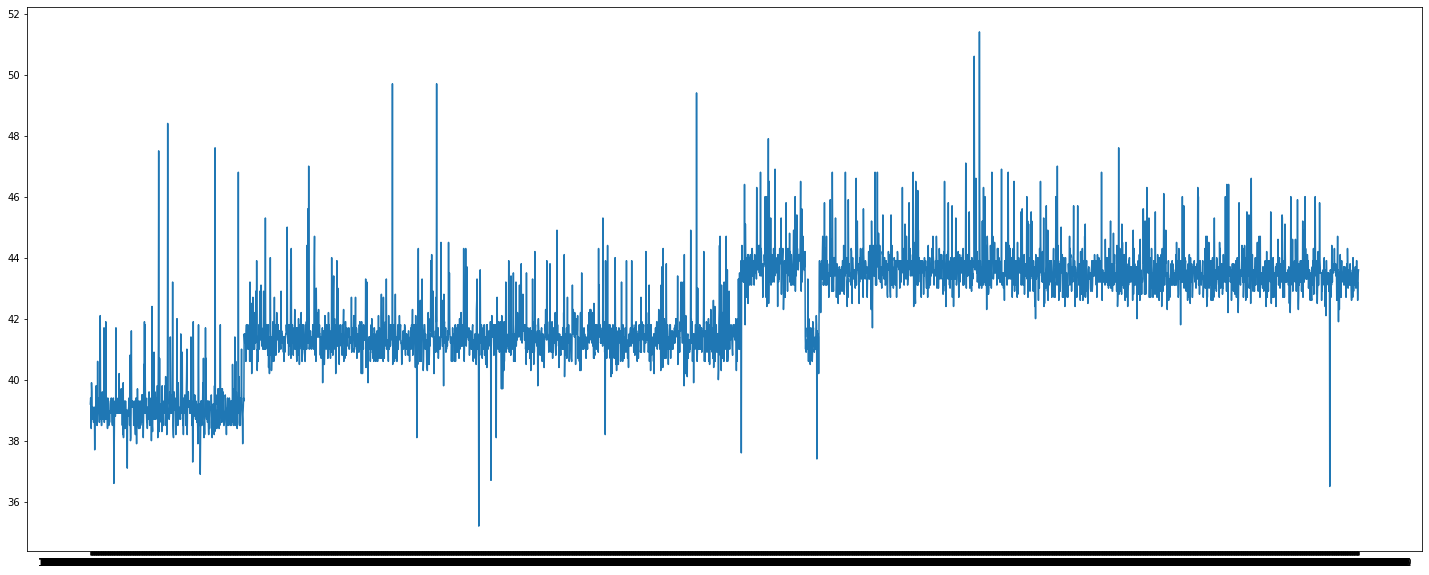

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(df1['Fecha/Hora'],df1['Temperatura'])

Train-Test split

In [ ]:
from sklearn.model_selection import train_test_split
df1_train, df1_test = train_test_split(df1, test_size=0.10, random_state=10)

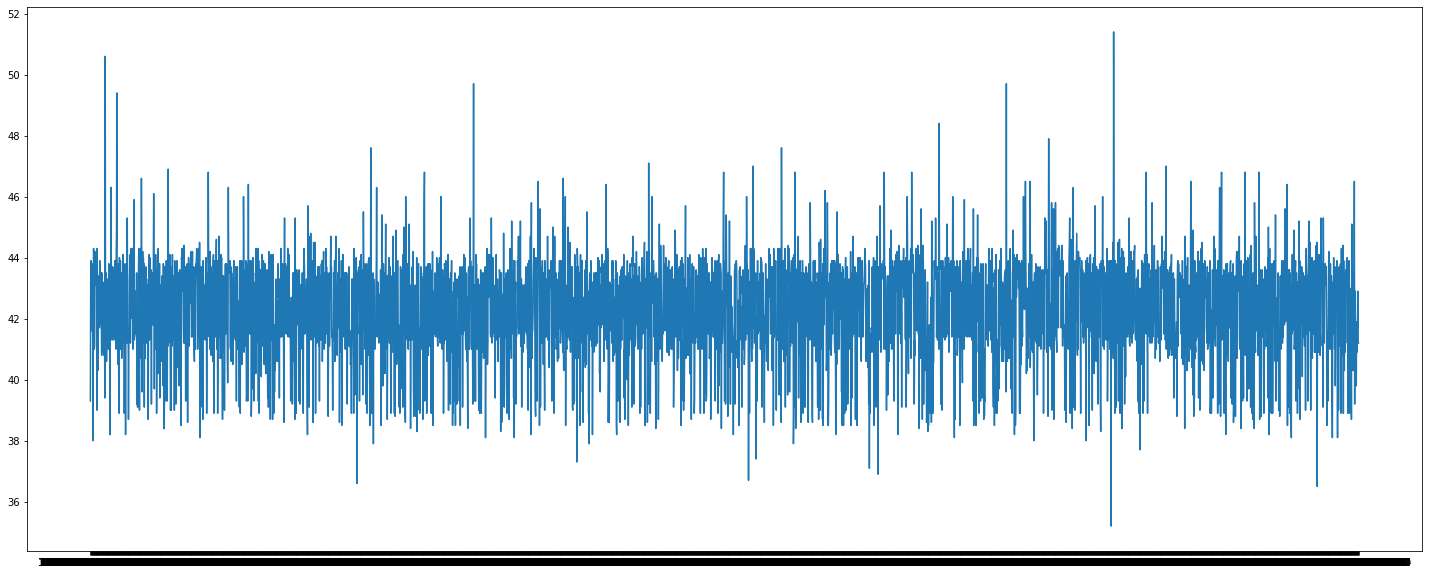

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(df1_train['Fecha/Hora'],df1_train['Temperatura'])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107]), <a list of 108 Text major ticklabel objects>)

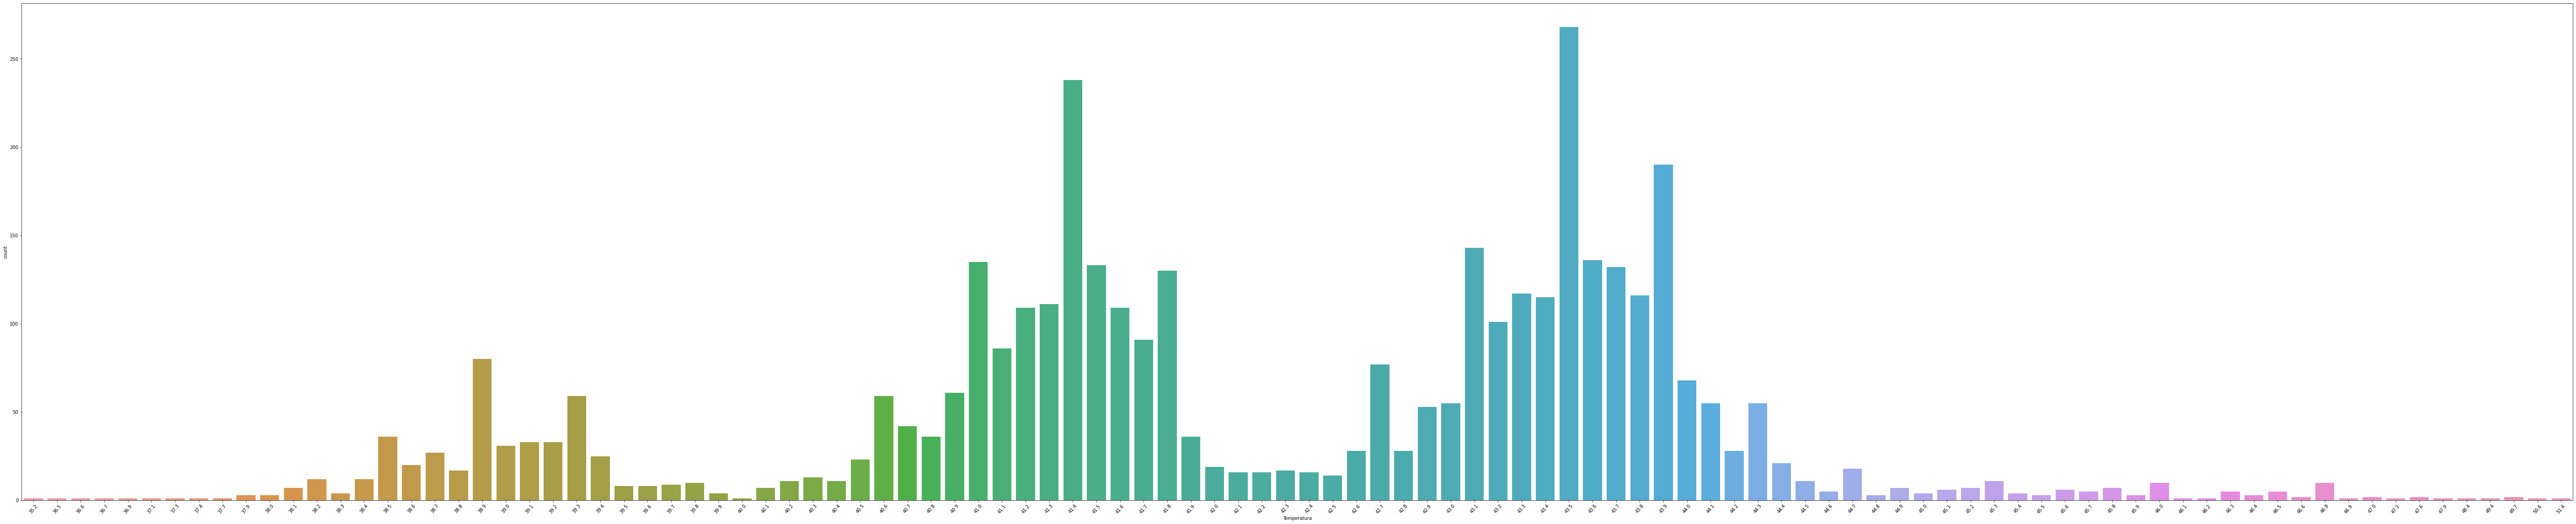

In [ ]:
#verificamos la distribución de los datos
plt.figure(figsize=(100,20))
sns.countplot(x='Temperatura',data=df1_train)
plt.xticks(rotation=50)

In [ ]:
dataframe = df1_train[['Fecha/Hora','Temperatura']]
display(dataframe.head())

Fecha/Hora  Temperatura
483   13-10-2022 13:09:30         39.3
3330  13-10-2022 14:43:42         43.2
3111  13-10-2022 14:26:57         43.9
3163  13-10-2022 14:28:23         43.7
1389  13-10-2022 13:39:55         41.6

In [ ]:
#Cambiar el nombre de las columnas
dataframe.columns = ['ds','y']
dataframe.head()

ds     y
483   13-10-2022 13:09:30  39.3
3330  13-10-2022 14:43:42  43.2
3111  13-10-2022 14:26:57  43.9
3163  13-10-2022 14:28:23  43.7
1389  13-10-2022 13:39:55  41.6

## Predicción usando prophet

In [ ]:
m = Prophet()
m.fit(dataframe)

#Prediccion un mes
future = m.make_future_dataframe(periods=3600, freq='S',include_history=True)

forecast = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/ul37y4ak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/xjvfudt3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95470', 'data', 'file=/tmp/tmpmfbmrmjg/ul37y4ak.json', 'init=/tmp/tmpmfbmrmjg/xjvfudt3.json', 'output', 'file=/tmp/tmpmfbmrmjg/prophet_modelnn_m0m5v/prophet_model-20221113224132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:41:34 - cmdstanpy - INFO - Chain 

In [ ]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7526 entries, 0 to 7525
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          7526 non-null   datetime64[ns]
 1   trend                       7526 non-null   float64       
 2   yhat_lower                  7526 non-null   float64       
 3   yhat_upper                  7526 non-null   float64       
 4   trend_lower                 7526 non-null   float64       
 5   trend_upper                 7526 non-null   float64       
 6   additive_terms              7526 non-null   float64       
 7   additive_terms_lower        7526 non-null   float64       
 8   additive_terms_upper        7526 non-null   float64       
 9   multiplicative_terms        7526 non-null   float64       
 10  multiplicative_terms_lower  7526 non-null   float64       
 11  multiplicative_terms_upper  7526 non-null   float64     

In [ ]:
forecast.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
7521 2022-10-13 16:13:08  43.129978   31.202616   56.046084    31.088090   
7522 2022-10-13 16:13:09  43.129893   30.585107   56.308451    31.084990   
7523 2022-10-13 16:13:10  43.129808   31.059655   55.827372    31.081890   
7524 2022-10-13 16:13:11  43.129723   31.070926   56.148855    31.078791   
7525 2022-10-13 16:13:12  43.129638   31.116307   56.034463    31.075691   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
7521    56.203227             0.0                   0.0                   0.0   
7522    56.205553             0.0                   0.0                   0.0   
7523    56.207835             0.0                   0.0                   0.0   
7524    56.210037             0.0                   0.0                   0.0   
7525    56.215758             0.0                   0.0                   0.0   

      multiplicative_terms  multiplicative_terms_lower  \
7521                   0.0                         0.0   
7522                   0.0                         0.0   
7523                   0.0                         0.0   
7524                   0.0                         0.0   
7525                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
7521                         0.0  43.129978  
7522                         0.0  43.129893  
7523                         0.0  43.129808  
7524                         0.0  43.129723  
7525                         0.0  43.129638

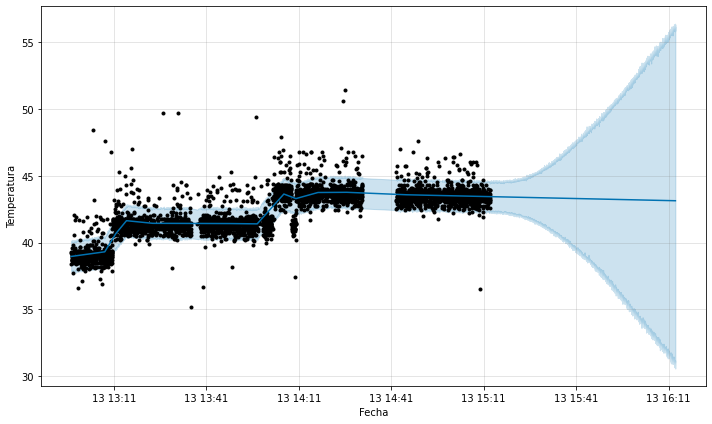

In [ ]:
figure = m.plot(forecast, xlabel='Fecha',ylabel='Temperatura')

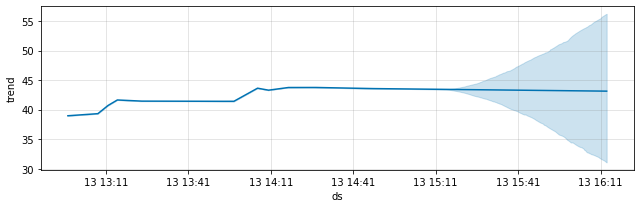

In [ ]:
figure = m.plot_components(forecast)

In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,horizon='30 minutes')

INFO:prophet:Making 2 forecasts with cutoffs between 2022-10-13 14:28:12 and 2022-10-13 14:43:12


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/r7a9a2rv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/5_vdl0yn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43222', 'data', 'file=/tmp/tmpmfbmrmjg/r7a9a2rv.json', 'init=/tmp/tmpmfbmrmjg/5_vdl0yn.json', 'output', 'file=/tmp/tmpmfbmrmjg/prophet_modele7_aj8he/prophet_model-20221113224136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:41:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/omjk0no6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/_0s0pz2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [ ]:
df_cv.head(7)

ds       yhat  yhat_lower  yhat_upper     y  \
0 2022-10-13 14:28:13  43.935311   42.727962   45.047600  42.6   
1 2022-10-13 14:28:15  43.936371   42.764532   45.220399  43.9   
2 2022-10-13 14:28:16  43.936902   42.683985   45.168644  43.5   
3 2022-10-13 14:28:18  43.937962   42.812495   45.239495  43.9   
4 2022-10-13 14:28:19  43.938493   42.801140   45.139321  43.4   
5 2022-10-13 14:28:21  43.939553   42.683296   45.068848  44.5   
6 2022-10-13 14:28:23  43.940614   42.741848   45.152345  43.7   

               cutoff  
0 2022-10-13 14:28:12  
1 2022-10-13 14:28:12  
2 2022-10-13 14:28:12  
3 2022-10-13 14:28:12  
4 2022-10-13 14:28:12  
5 2022-10-13 14:28:12  
6 2022-10-13 14:28:12

# Prueba de error

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape     mdape     smape  \
0 0 days 00:02:17  0.627146  0.791925  0.599317  0.013678  0.010836  0.013654   
1 0 days 00:02:18  0.626335  0.791413  0.598495  0.013659  0.010836  0.013635   
2 0 days 00:02:19  0.630937  0.794315  0.602559  0.013754  0.010836  0.013729   
3 0 days 00:02:20  0.637261  0.798286  0.607162  0.013862  0.010836  0.013835   
4 0 days 00:02:21  0.635415  0.797129  0.603730  0.013783  0.010812  0.013757   

   coverage  
0  0.887417  
1  0.887417  
2  0.887417  
3  0.887417  
4  0.887417

/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



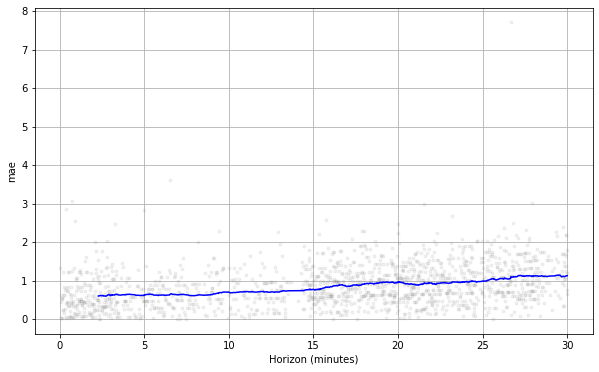

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



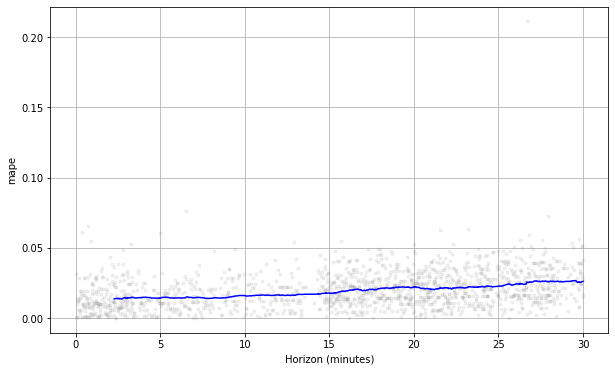

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

Gracias al entrenamiento se logró un mejor resultado

In [ ]:
#Agregar Holidays y changepoints para des-automatizar el algoritmo, opcional por el momento, lo importante es lo de arriba 

#Pruebas con manipulacion

##Holidays y changepoints

In [ ]:
#Holidays
temp_season = pd.DataFrame({
  'holiday': 'temperature season',
  'ds': pd.to_datetime(['13-10-2022 13:36','13-10-2022 13:38:53',
                        '13-10-2022 13:58:49','13-10-2022 13:58:59',
                        '13-10-2022 14:20:24','13-10-2022 14:20:55'])
})

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/bmy43z7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/vejxek1i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81697', 'data', 'file=/tmp/tmpmfbmrmjg/bmy43z7l.json', 'init=/tmp/tmpmfbmrmjg/vejxek1i.json', 'output', 'file=/tmp/tmpmfbmrmjg/prophet_model1ogmk4_0/prophet_model-20221113224142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:41:42 - cmdstanpy - INFO - Chain 

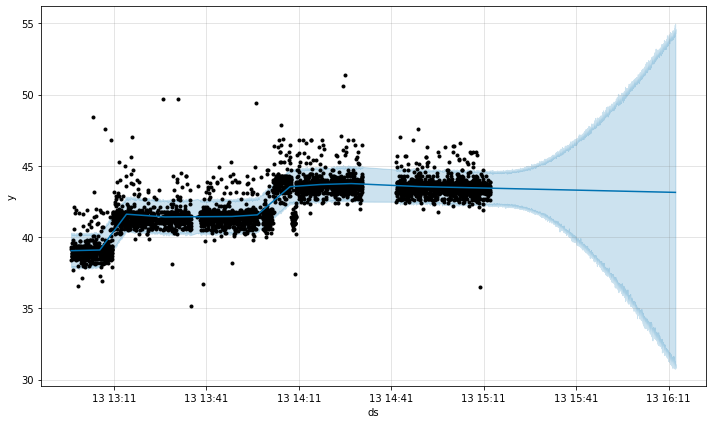

In [ ]:
s = Prophet(holidays=temp_season, holidays_prior_scale=0.1, n_changepoints=10)
s.fit(dataframe)
future_data = s.make_future_dataframe(periods=3600, freq='S',include_history=True)
 
#forecast the data for future data
forecast_data = s.predict(future_data)
s.plot(forecast_data);

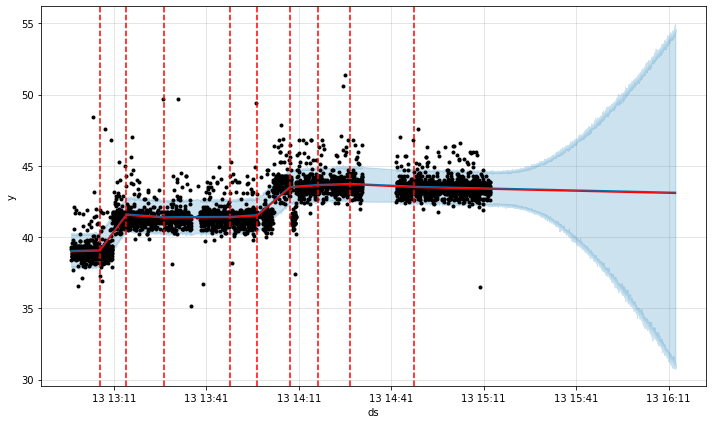

In [ ]:
from prophet.plot import add_changepoints_to_plot
fig = s.plot(forecast_data)
a = add_changepoints_to_plot(fig.gca(), s, forecast_data)

In [ ]:
#pro_change= Prophet(n_changepoints=20, changepoint_prior_scale=0.01)
#forecast = pro_change.fit(dataframe).predict(future)
#fig= pro_change.plot(forecast);
#a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

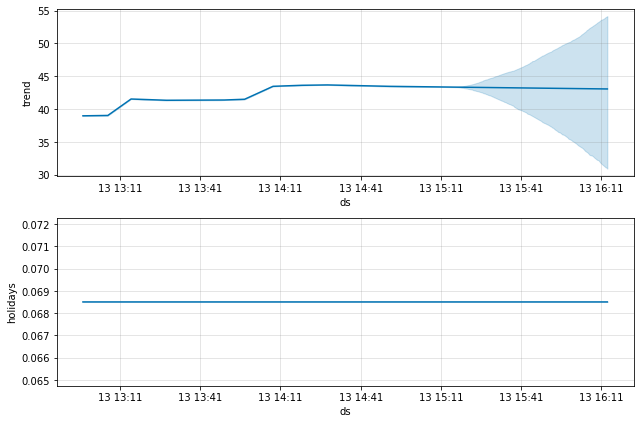

In [ ]:
figure_h = s.plot_components(forecast_data)

In [ ]:
from prophet.diagnostics import cross_validation
df_cv_h = cross_validation(s,horizon='30 minutes')

INFO:prophet:Making 2 forecasts with cutoffs between 2022-10-13 14:28:12 and 2022-10-13 14:43:12


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/qsyy19cb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/sukn72o_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89925', 'data', 'file=/tmp/tmpmfbmrmjg/qsyy19cb.json', 'init=/tmp/tmpmfbmrmjg/sukn72o_.json', 'output', 'file=/tmp/tmpmfbmrmjg/prophet_modelikn7y6wb/prophet_model-20221113224146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:41:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/p3v0gue3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfbmrmjg/dwz23mdk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [ ]:
df_cv_h.head(7)

ds       yhat  yhat_lower  yhat_upper     y  \
0 2022-10-13 14:28:13  43.936725   42.629544   45.152105  42.6   
1 2022-10-13 14:28:15  43.937719   42.566121   45.246793  43.9   
2 2022-10-13 14:28:16  43.938215   42.739169   45.162340  43.5   
3 2022-10-13 14:28:18  43.939209   42.705628   45.159374  43.9   
4 2022-10-13 14:28:19  43.939705   42.696278   45.199155  43.4   
5 2022-10-13 14:28:21  43.940699   42.662527   45.184269  44.5   
6 2022-10-13 14:28:23  43.941692   42.657611   45.227534  43.7   

               cutoff  
0 2022-10-13 14:28:12  
1 2022-10-13 14:28:12  
2 2022-10-13 14:28:12  
3 2022-10-13 14:28:12  
4 2022-10-13 14:28:12  
5 2022-10-13 14:28:12  
6 2022-10-13 14:28:12

In [ ]:
from prophet.diagnostics import performance_metrics
df_p_h = performance_metrics(df_cv_h)
df_p_h.head()

horizon       mse      rmse       mae      mape     mdape     smape  \
0 0 days 00:02:17  0.606332  0.778673  0.583330  0.013305  0.010792  0.013290   
1 0 days 00:02:18  0.605336  0.778033  0.582057  0.013276  0.010792  0.013261   
2 0 days 00:02:19  0.609406  0.780644  0.585891  0.013365  0.010792  0.013349   
3 0 days 00:02:20  0.615739  0.784690  0.590423  0.013471  0.010793  0.013454   
4 0 days 00:02:21  0.614070  0.783626  0.587150  0.013396  0.010792  0.013379   

   coverage  
0   0.92053  
1   0.92053  
2   0.92053  
3   0.92053  
4   0.92053